# Introduction
This notebook demonstrates the use of PanCAKE with the MIRI coronagraphs, and contrasts PanCAKE with default Pandeia coronagraphy calculations. In particular, it provides examples of:
* Constructing a MIRI scene in both Pandeia and PanCAKE
* Importing a MIRI scene built in Pandeia into PakCAKE
* Engine calculations using Pandeia's precomputed PSF library, in both Pandeia and PanCAKE
* Comparisons of Pandeia's precomputed PSF library with PanCAKE's on-the-fly PSF generation
* Comparisons of on-the-fly PSF generation with varying numbers of wavelength bins

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.perform_calculation import perform_calculation

from pancake import scene, analysis, transformations, engine

from copy import deepcopy
import numpy as np

# Constructing a Scene

We'll start by defining the source and instrument properties for our desired observation. 

In [2]:
target_mV = 4.7
ref_mV = 3.

target_Sp = 'a5v'
ref_Sp = 'a3v'

subarray = 'mask1065'
filter_c = 'f1065c'
mask_c = 'fqpm1065'

ngroup = 10
nint = 1

Now we'll create in a MIRI template from Pandeia and configure the instrument for our observation. (In this case, it's already configured for a F1065C observation, but we'll demonstrate setting the calculation keys regardless.)

In [3]:
# Load the template
config = build_default_calc('jwst', 'miri', 'coronagraphy')

# Set the coronagraph and filter
config['configuration']['detector']['subarray'] = subarray
config['configuration']['detector']['ngroup'] = ngroup
config['configuration']['instrument']['aperture'] = mask_c
config['configuration']['instrument']['filter'] = filter_c

This template contains a scene with a single star. We'll set the star properties and then duplicate it to create a planetary companion.

In [4]:
# Pull out the target (the first entry in the 'scene' list)
targetstar = config['scene'][0]
targetstar['spectrum']['normalization']['norm_flux'] = target_mV
targetstar['spectrum']['sed']['key'] = target_Sp
targetstar['id'] = 1

# Copy the target star and turn it into a planet
planetA = deepcopy(targetstar)
planetA['id'] = 2 #each source must have a unique ID, starting at 1

# A different way to normalize source flux
planetA['spectrum']['normalization']['bandpass'] = 'miri,imaging,f1500w'
planetA['spectrum']['normalization']['norm_flux'] = 15.3
planetA['spectrum']['normalization']['type'] = 'jwst'
planetA['spectrum']['sed']['sed_type'] = 'blackbody'
planetA['spectrum']['sed']['temp'] = 900.
del planetA['spectrum']['sed']['key'] #unnecessary now

# Source offset
planetA['position']['x_offset'] = 2.3 #arcsec
planetA['position']['y_offset'] = 3.1

# Update calculation file with the new planet
config['scene'].append(planetA)

# Update Pandeia's contrast angle to the planet's offset
config['strategy']['contrast_azimuth'] = 40.
config['strategy']['contrast_separation'] = 1.

Create the reference scene for PSF subtraction:

In [5]:
# We adopt a brighter but spectrally-mismatched reference
config['strategy']['psf_subtraction_source']['spectrum']['normalization']['norm_flux'] = ref_mV
config['strategy']['psf_subtraction_source']['spectrum']['sed']['key'] = ref_Sp
config['strategy']['psf_subtraction_source']['id'] = 3

And now we'll plot the two scenes we've constructed

(0, 5.0)

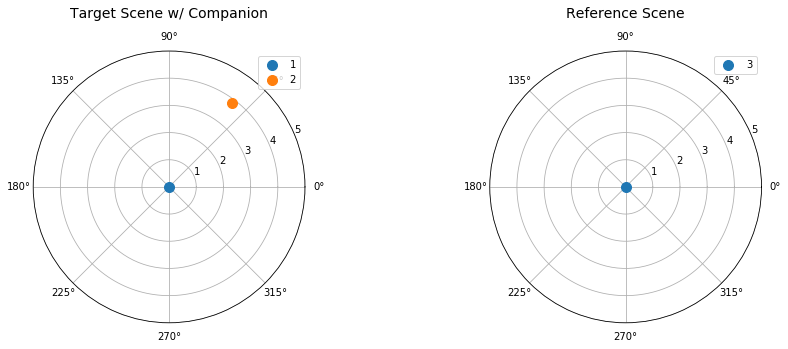

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(121,polar=True)
scene.plot_scene(config['scene'],'Target Scene w/ Companion',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)
plt.subplot(122,polar=True)
scene.plot_scene([config['strategy']['psf_subtraction_source']],'Reference Scene',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)

# Run the Pandeia Engine

Now we pass our calculation files to the pandeia engine to create the slope images (and a number of other products).

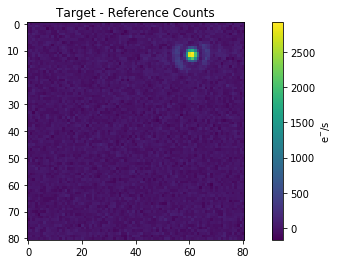

In [7]:
pandeia_result = perform_calculation(deepcopy(config))

subtracted_slope = pandeia_result['2d']['detector']

plt.figure(figsize=(10,4))
plt.imshow(subtracted_slope)
plt.title('Target - Reference Counts')
plt.colorbar().set_label('e$^{-}$/s')

In order to run the same calculation via panCAKE, the convenience functions ``engine.import_pandeia_calculation`` and ``engine.calculate_subtracted`` will generate similar results to Pandeia's optimally-subtracted calculation:

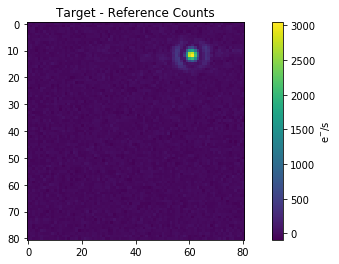

In [8]:
pancake_result = engine.calculate_subtracted(config)

subtracted_slope = pancake_result['subtracted']

plt.figure(figsize=(10,4))
plt.imshow(subtracted_slope)
plt.title('Target - Reference Counts')
plt.colorbar().set_label('e$^{-}$/s')

### Wave Sampling

An aside on performance and accuracy: The ```engine.options.wave_sampling``` parameter provides a hook into the wavelength sampling of the 3D (x,y,wavelength) cube. By default, Pandeia adopts some large value for the wavelength sampling (typically 150+); however, this is the primary time sink in the calculation. Setting ```engine.options.wave_sampling = 11``` while developing your simulation provides dramatic time savings while getting within ~5% of the "true" value. By ```engine.options.wave_sampling = 41```, one can expect agreement to within roughly 1%.

### On-the-fly PSF Calculations

The Pandeia engine relies on a library of precomputed PSFs that are sparsely sampled across the coronagraphic field of view. For the MIRI coronagraphs, this sparse sampling will often be insufficient for accurately capturing PSF variations arising from small offsets.

Pandeia-Coronagraphy gives the option (```engine.options.on_the_fly_PSFs```) to circumvent the use of this precomputed library and force recomputing each PSF on the fly in WebbPSF. We'll toggle it to True, at the cost of some speed.

The example below shoes a calculation with 11 data points (using on-the-fly PSFs), and one with 51.

In [9]:
engine.options.on_the_fly_PSFs = True

engine.options.wave_sampling = 11
pancake_result_11 = engine.calculate_subtracted(config)
subtracted_slope_11 = pancake_result_11['subtracted']

engine.options.wave_sampling = 51
pancake_result_51 = engine.calculate_subtracted(config)
subtracted_slope_51 = pancake_result_51['subtracted']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(subtracted_slope_11)
plt.title('11 Wavelength Bins')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(subtracted_slope_51)
plt.title('51 Wavelength Bins')
plt.colorbar().set_label('e$^{-}$/s')


 ***********  ERROR  ******  ERROR  ******  ERROR  ******  ERROR  ***********
 *                                                                          *
 *  WebbPSF requires several data files to operate.                         *
 *  These files could not be located automatically at this time, or this    *
 *  version of the software requires a newer set of reference files than    *
 *  you have installed.  For more details see:                              *
 *                                                                          *
 *           http://pythonhosted.org/webbpsf/installation.html              *
 *                                                                          *
 *  under "Installing the Required Data Files".                             *
 *  WebbPSF will not be able to function properly until the appropriate     *
 *  reference files have been downloaded to your machine and installed.     *
 *                                                             

OSError: WEBBPSF_PATH (/Users/york/STScI/corona3/webbpsf-data) is not a valid directory path!

The capabilities of on-the-fly PSF calculations become most important when considering the effect of target acquisition (TA) errors. Although the ``engine.calculate_subtracted`` function offers the ability to generate its own TA errors, for this example the errors will be added directly to the configuration dictionary so that they are the same for Pandeia and PanCAKE.

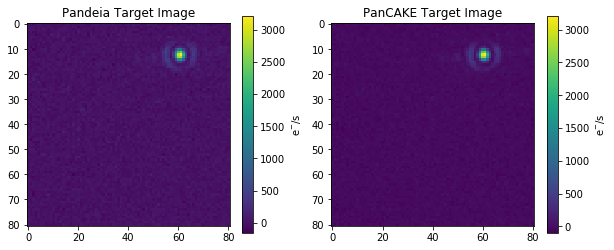

In [11]:
config_with_errors = deepcopy(config)
target_x_err, target_y_err = scene.get_ta_error()
scene.offset_scene(config_with_errors['scene'], target_x_err, target_y_err)
reference_x_err, reference_y_err = scene.get_ta_error()
scene.offset_scene([config_with_errors['strategy']['psf_subtraction_source']], reference_x_err, reference_y_err)

pandeia_result_with_errors = perform_calculation(deepcopy(config_with_errors))

engine.options.wave_sampling = 21
pancake_result_with_errors = engine.calculate_subtracted(config_with_errors)

pandeia_slope = pandeia_result_with_errors['2d']['detector']
pancake_slope = pancake_result_with_errors['subtracted']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(pandeia_slope)
plt.title('Pandeia Target Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(pancake_slope)
plt.title('PanCAKE Target Image')
plt.colorbar().set_label('e$^{-}$/s')